let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0
let's pick some samples for validation
(67, 160, 160, 8) (67, 160, 160, 1) 1.0 -1.0 1.0 0.0
start train net
(255, 160, 160, 8) (255, 160, 160, 1) 1.0 -1.0 1.0 0.0
loading weights
creat

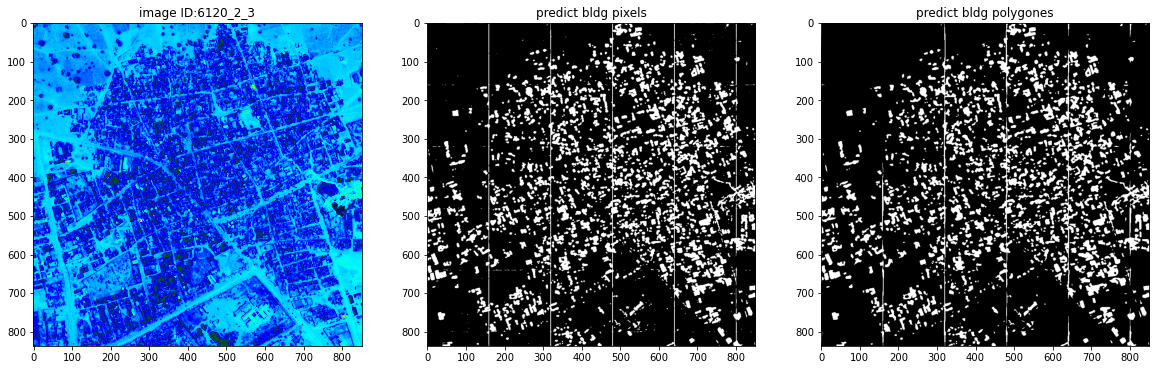

In [1]:
######### SATELLITE IMAGERY FEATURE DETECTION : SEMANTIC SEGMENTATION ########
# author= "n01z3" [Modified by Me]
# packaged by conda-forge | (default, Mar 23 2020, 23:03:20) Ver. 3.7.6
# using 'tensorflow._api.v2.version'

import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Convolution2D, UpSampling2D, Reshape, core, Dropout, Cropping2D, ZeroPadding2D, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
import zipfile


N_Cls = 1
inDir = '../input/dstl-satellite-imagery-feature-detection'
#inDir = '/home/n01z3/dataset/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv.zip')
GS = pd.read_csv(inDir + '/grid_sizes.csv.zip', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv.zip'))
ISZ = 160
smooth = 1e-12

os.mkdir('/kaggle/data/')
os.mkdir('/kaggle/msk/')
os.mkdir('/kaggle/weights/')
os.mkdir('/kaggle/subm/')

def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    zip_path = '../input/dstl-satellite-imagery-feature-detection/sixteen_band.zip'
    tgtImg = '{}_M.tif'.format(image_id)
    with zipfile.ZipFile(zip_path) as myzip:
        files_in_zip = myzip.namelist()
        for fname in files_in_zip:
            if fname.endswith(tgtImg):
                with myzip.open(fname) as myfile:
                    img = tiff.imread(myfile)
                    img = np.rollaxis(img, 0, 3)
                    return img


def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def stick_all_train():
    print("let's stick all imgs together")
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print(len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print (img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print (np.amax(y), np.amin(y))

    np.save('/kaggle/data/x_trn_%d' % N_Cls, x)
    np.save('/kaggle/data/y_trn_%d' % N_Cls, y)


def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2
    x, y = [], []
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 1, 2, 3)) - 1, np.transpose(y, (0, 1, 2, 3))
    print (x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
#     y = np.delete(y, 2)
#     y = np.delete(y, 3)
    return x, y


def make_val():
    print ("let's pick some samples for validation")
    img = np.load('/kaggle/data/x_trn_%d.npy' % N_Cls)
    msk = np.load('/kaggle/data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save('/kaggle/data/x_tmp_%d' % N_Cls, x)
    np.save('/kaggle/data/y_tmp_%d' % N_Cls, y)

def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2])
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1])
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

def get_unet():
    concat_axis = 3

    inputs = Input((ISZ, ISZ, 8))
    
    conv1 = Conv2D(32, (3, 3), padding="same", name="conv1_1", activation="relu", data_format="channels_last")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv3)

    up_conv3 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv3)
    ch, cw = get_crop_shape(conv2, up_conv3)
    crop_conv2 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv2)
    up8   = concatenate([up_conv3, crop_conv2], axis=concat_axis)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv8)

    up_conv8 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv1)
    up9   = concatenate([up_conv8, crop_conv1], axis=concat_axis)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv9)

    ch, cw = get_crop_shape(inputs, conv9)
    conv9  = ZeroPadding2D(padding=(ch[0],cw[0]), data_format="channels_last")(conv9)
    conv10 = Conv2D(N_Cls, (1, 1), data_format="channels_last", activation="sigmoid")(conv9)
      
    model = Model(inputs=inputs, outputs=conv10)
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


def calc_jacc(model):
    img = np.load('/kaggle/data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('/kaggle/data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print (i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


'''def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours
    (
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP,
        cv2.CHAIN_APPROX_TC89_KCOS
    )
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons
'''
def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


def train_net():
    print ("start train net")
    x_val, y_val = np.load('/kaggle/data/x_tmp_%d.npy' % N_Cls), np.load('/kaggle/data/y_tmp_%d.npy' % N_Cls)
    img = np.load('/kaggle/data/x_trn_%d.npy' % N_Cls)
    msk = np.load('/kaggle/data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    print("loading weights")
#     model.load_weights('weights/unet_10_jk0.7878')
    print("creating checkpoint")
    model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    print("start fitting")
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, epochs=10, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print ('val jk', score)
        model.save_weights('/kaggle/weights/unet_10_jk%.4f' % score)

    return model


def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 1, 2, 3)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
#             print(tmp[j].shape)
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = np.transpose(tmp[j], (2, 0, 1))

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]


def predict_test(model, trs):
    print ("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('/kaggle/msk/10_%s' % id, msk)
        if i % 100 == 0: print (i, id)


def make_submit():
    print ("make submission file")
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv.zip'))
    print (df.head())
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('/kaggle/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print (idx)
    print( df.head())
    df.to_csv('subm/1.csv', index=False)


'''
def check_predict(id='6120_2_3'):
    print ("check predict")
    model = get_unet()
    model.load_weights('/kaggle/weights/unet_10_jk%.4f' % score)
    #trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    msk = predict_id(id, model, trs)#[0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    m = M(id)
    print(m.shape)
    class_list = ["Buildings", "Misc.Manmade structures" ,"Road",\
                  "Track","Trees","Crops","Waterway","Standing water",\
                  "Vehicle Large","Vehicle Small"]
    
    img = np.zeros((m.shape[0],m.shape[1],3))
    img[:,:,0] = m[:,:,4] #red
    img[:,:,1] = m[:,:,2] #green
    img[:,:,2] = m[:,:,1] #blue
    
    for i in range(10):
        plt.figure(figsize=(20,20))
        ax1 = plt.subplot(131)
        ax1.set_title('image ID:6120_2_3')
        ax1.imshow(stretch_n(img))
        ax2 = plt.subplot(132)
        ax2.set_title("predict "+ class_list[i] +" pixels")
        ax2.imshow(msk[i], cmap=plt.get_cmap('gray'))
        ax3 = plt.subplot(133)
        ax3.set_title("predict " + class_list[i] + " polygones")
        ax3.imshow(mask_for_polygons(mask_to_polygons(msk[i], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))
        plt.show()  
'''
def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights('/kaggle/weights/unet_10_jk%.4f' % score)

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(20,20))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))
    plt.show()
        
if __name__ == '__main__':
    
    stick_all_train()
    
    make_val()
    
    model = train_net()
    
    score, trs = calc_jacc(model)
    
    predict_test(model, trs)
    
    #make_submit()

    check_predict('6120_2_2')